# Measurement - Synthetic control method (SCM)

## What is SCM

SCM is a quasi-experimental design to do causal inference, similar to diff-in-diff (DID). 

In the situation where the random selection is not feasible, or there might be spillovers between treatments and control, quasi-experiments are used to measure the impact of the treatments. 

The challenge with DID method is that it requires similar covariates between the treated and control groups, which is not always feasible. 
Another problem is that if the frowth trend from the treatment is different from the trend of the control, DID will be biased, a common problem with non-random data. 


To work around with this, we use what is known as synthetic control method to measure the treatment outcome against a look-alike generated control population. 
SCM generates control set by providing formal criteria and explains the relative importance of each donor by employing linear models. 
What is more, the choice of synthetic control does not rely on post-intervention outcomes, making it impossible to cherry-pick the study design that may affect the conclusions. 


### When to use SCM
SCM is best method when the experiment takes place at aggregate level, eg. country, state, county, and there are only a handful of control and test cases. Due to these charateristics, SCM is the go-to method for large-scale program evaluation. 


### Strengths of SCM
- First and foremost, SCM generated counterfactual is almost the same the treated case. 
- Secondly, SCM is easy to explain since it mostly employing linear models. You can explain the weights of each covariates by using the weights of the model. 


## Challenges with SCM
- By design, SCM works at aggregate level, not individual level. 
- Also, it requires a relatively long pre-treatment period so that it could model good counterfactual data. 

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import scipy.stats as st
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
import pandas as pd
import warnings

warnings.simplefilter("ignore")

pd.set_option("display.max_columns", 8)

<IPython.core.display.Javascript object>

## California proposition 99

To see it in action, let's consider the problem of estimating the effect of cigarette taxation on its consumption. 

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as Proposition 99. 

“Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements.”

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the years 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

In [3]:
# # Download data from online source, and store locally
# df = pd.read_csv('https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv',
#                 sep = ';')
# df.to_csv('data/california_prop99.csv')

df = pd.read_csv("data/california_prop99.csv")

<IPython.core.display.Javascript object>

In [4]:
df.head()

,Unnamed: 0,State,Year,PacksPerCapita,treated
0,0,Alabama,1970,89.800003,0
1,1,Arkansas,1970,100.300003,0
2,2,Colorado,1970,124.800003,0
3,3,Connecticut,1970,120.000000,0
4,4,Delaware,1970,155.000000,0


<IPython.core.display.Javascript object>

In [5]:
from matplotlib import pyplot as plt
import numpy as np

# style plots


def write_local_style():
    mpltxt = """patch.linewidth: 0.5\npatch.facecolor: 348ABD  \npatch.edgecolor: EEEEEE\n
    patch.antialiased: True\nlines.solid_capstyle: round\nfont.size: 10.0\n
    font.family: Trebuchet MS\ntext.color: 575757\naxes.facecolor: none\n
    axes.edgecolor: 575757\naxes.spines.left   : True   \naxes.spines.bottom : True\n
    axes.spines.top    : False\naxes.spines.right  : False\naxes.linewidth: 1\naxes.grid: True\n
    axes.titlesize: x-large\naxes.labelsize: large\naxes.labelcolor: 575757\naxes.axisbelow: True       \n
    axes.prop_cycle: cycler('color', ['29ba74', '6e6f73', '295e7e', '670f31', '98b21c', '9a9a9a', '3ead92'])\n
    xtick.color: 575757\nxtick.direction: out\nxtick.labelsize : medium\nxtick.major.width: 1\n
    xtick.major.size: 4      \nytick.color: 575757\nytick.direction: out\nytick.labelsize : medium\n
    ytick.major.width: 1\nytick.major.size: 4\ngrid.color: none\nfigure.facecolor: none\n
    figure.edgecolor: 0.50\nfigure.dpi: 150      \n"""

    with open("data/style/mystyle.mplstyle", "w+") as f:
        f.write(mpltxt)


write_local_style()
plt.style.use("data/style/mystyle.mplstyle")

<IPython.core.display.Javascript object>

Here the plot shows the difference between California pre and post vs national average pre and post.

A few observations from the plot:
- Apparently people in California bought fewer cigarettes than national average. 
- There is a downwards trending in both California and other states of the country
- It seems like the decreasing trend in California were accelerated after the proposition 99, but we can't say it for sure. 

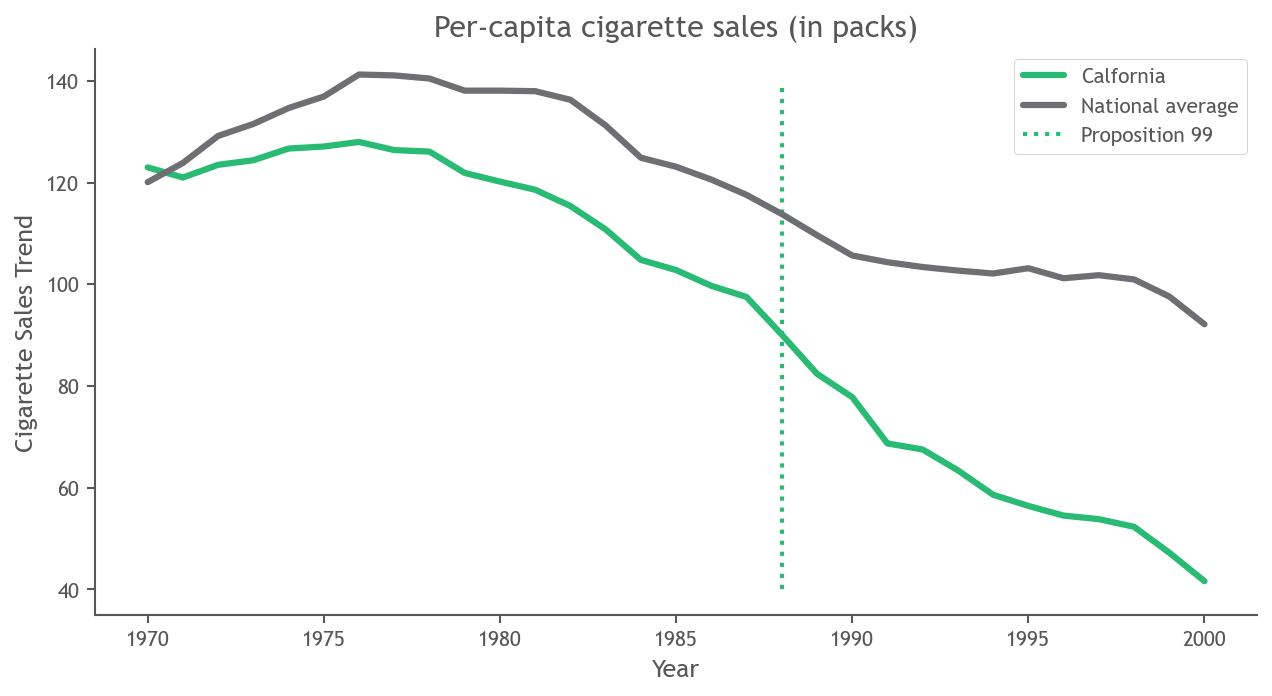

<IPython.core.display.Javascript object>

In [6]:
ax = plt.subplot(1, 1, 1)

df.assign(
    california=np.where(df["State"] == "California", "Calfornia", "National average")
).groupby(["Year", "california"])["PacksPerCapita"].mean().reset_index().pivot(
    "Year", "california", "PacksPerCapita"
).plot(
    ax=ax, figsize=(10, 5), lw=3
)

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

To answer the question whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control, which means we will build a fake state that resembles very closely the trend of California. 

### Clean data for downstream work

Ideally we want to see the data with each state as columns, and dates as rows, so that we can use any machine learning model to use other states as variables and we represent the outcome as a weighted average of the units (i.e. a dot product of the each state PacksPerCapita and regression weight).

In [7]:
inverted = df.pivot(index="State", columns="Year")[  # filter pre-intervention period
    "PacksPerCapita"
].T  # flip the table to have one column per state

inverted.head()

State,Alabama,Arkansas,California,Colorado,...,Virginia,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,
1970,89.800003,100.300003,123.000000,124.800003,...,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,125.500000,...,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,134.300003,...,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,137.899994,...,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,132.800003,...,149.600006,119.900002,111.800003,145.800003


<IPython.core.display.Javascript object>

## Implement SCM

Here we will try to build a fake unit that resemble the treated unit. 

Linear regression is a very good model to build counterfactual becasue it allows us to find the weights of each state that can be rebuild to the new fake state. 

In [8]:
# training data would be before 1989 when the state of California introduced the Act
train_df = inverted.loc[:1988]
train_df.shape

(19, 39)

<IPython.core.display.Javascript object>

In [9]:
def create_synthetic_control(train_df, inverted, pool, model, state="California"):
    # other states
    other_states = [x for x in pool if x != state]

    y = train_df[state]  # state of california
    X = train_df[other_states]  # other states

    weights_regression = model.fit(X, y).coef_
    weights = pd.DataFrame(
        data={"State": X.columns, "weights": weights_regression.round(3)}
    )
    print(f"State weights : ")
    print(f"{weights[weights['weights']!=0].sort_values('weights', ascending=False)}")

    # Forming the synthetic control
    synth_control = inverted[other_states].dot(weights_regression)

    cal = inverted[[state]]
    cal["synth"] = synth_control
    cal["gap"] = cal[state] - synth_control
    return cal, weights

<IPython.core.display.Javascript object>

In [10]:
state_pools = train_df.columns
model = LinearRegression(fit_intercept=False)
cal, weights = create_synthetic_control(
    train_df, inverted, state_pools, model=model, state="California"
)

State weights : 
             State  weights
3      Connecticut    0.155
35   West Virginia    0.143
17         Montana    0.142
19          Nevada    0.141
18        Nebraska    0.112
32            Utah    0.109
7         Illinois    0.107
10          Kansas    0.107
2         Colorado    0.104
31           Texas    0.083
36       Wisconsin    0.081
22  North Carolina    0.075
11        Kentucky    0.068
21      New Mexico    0.067
14       Minnesota    0.060
12       Louisiana    0.056
6            Idaho    0.051
1         Arkansas    0.036
13           Maine    0.016
9             Iowa    0.011
20   New Hampshire    0.010
5          Georgia    0.009
0          Alabama   -0.002
24            Ohio   -0.009
29    South Dakota   -0.011
26    Pennsylvania   -0.025
27    Rhode Island   -0.026
4         Delaware   -0.027
34        Virginia   -0.028
37         Wyoming   -0.029
16        Missouri   -0.030
25        Oklahoma   -0.047
23    North Dakota   -0.066
28  South Carolina   -0.073
8  

<IPython.core.display.Javascript object>

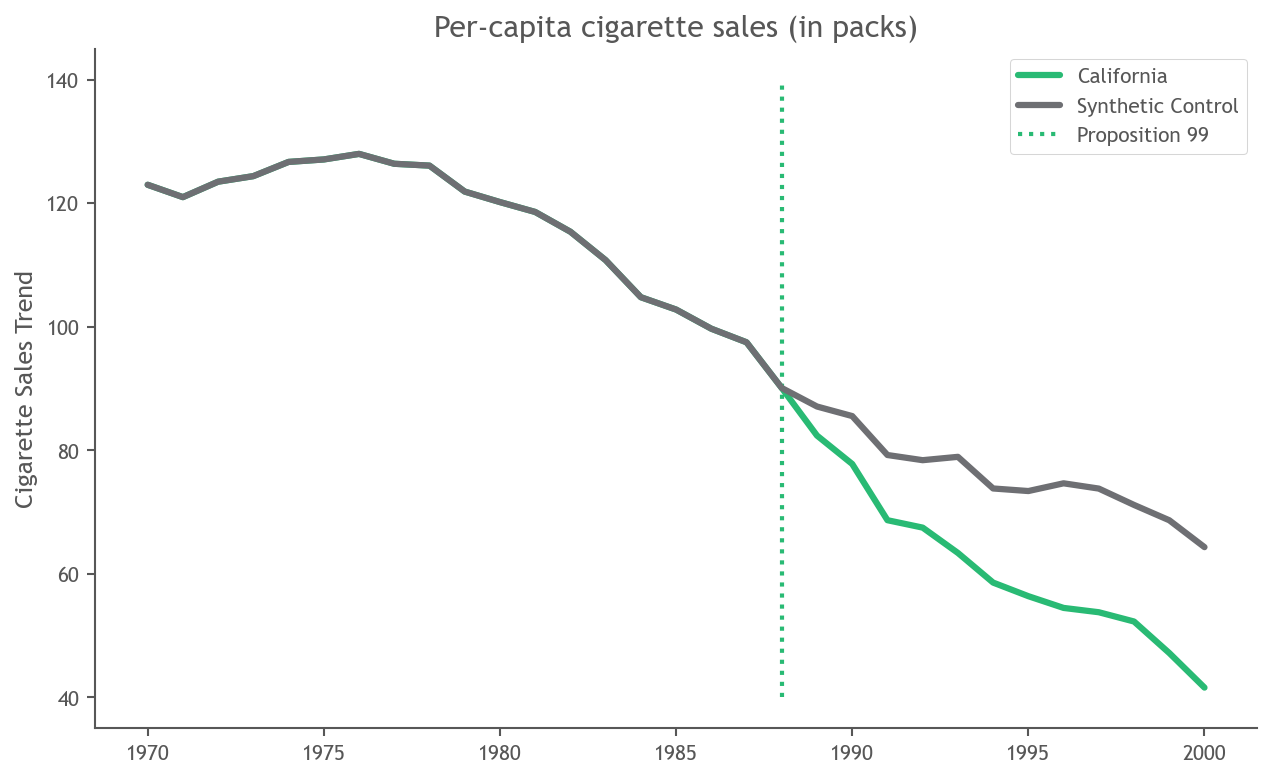

<IPython.core.display.Javascript object>

In [11]:
def print_actual_synth(df, state="California"):
    plt.figure(figsize=(10, 6))

    plt.plot(
        df.index,
        df[state],
        label=state,
        lw=3,
    )
    plt.plot(
        df.index,
        df["synth"],
        label="Synthetic Control",
        lw=3,
    )

    plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
    plt.ylabel("Cigarette Sales Trend")
    plt.title("Per-capita cigarette sales (in packs)")
    plt.legend()


print_actual_synth(cal, state="California")

This looks perfect. 

But wait, this might be a little too perfect. So, there might be 2 issues:
   
1. The pre-intervention fit so perfectly that it almost seem to be overfit. As a matter of fact, it is overfit because the model has way more features (38 states) to play around with to fit the limited observation (19 rows). It can bas

2. The weights of each states do not make any business sense. Technically this is not wrong, but the negative value of some of the states could not be explained. Does the -0.13 mean that for each pack of the cigarette not sold in some state, there will be one pack sold in California? 


To combat overfitting, we can do a few things. 
1. Use regularization. Employ techniques like Lasso, Ridge or ElasticNet to minimize the weights. 
2. Constrain the weights to positive only. Now the syntheic control will be a convex combination of the units in the other states. 

State weights : 
            State  weights
2        Colorado    0.283
19         Nevada    0.217
3     Connecticut    0.132
7        Illinois    0.044
17        Montana    0.042
6           Idaho    0.039
20  New Hampshire    0.038
9            Iowa    0.028
37        Wyoming    0.003


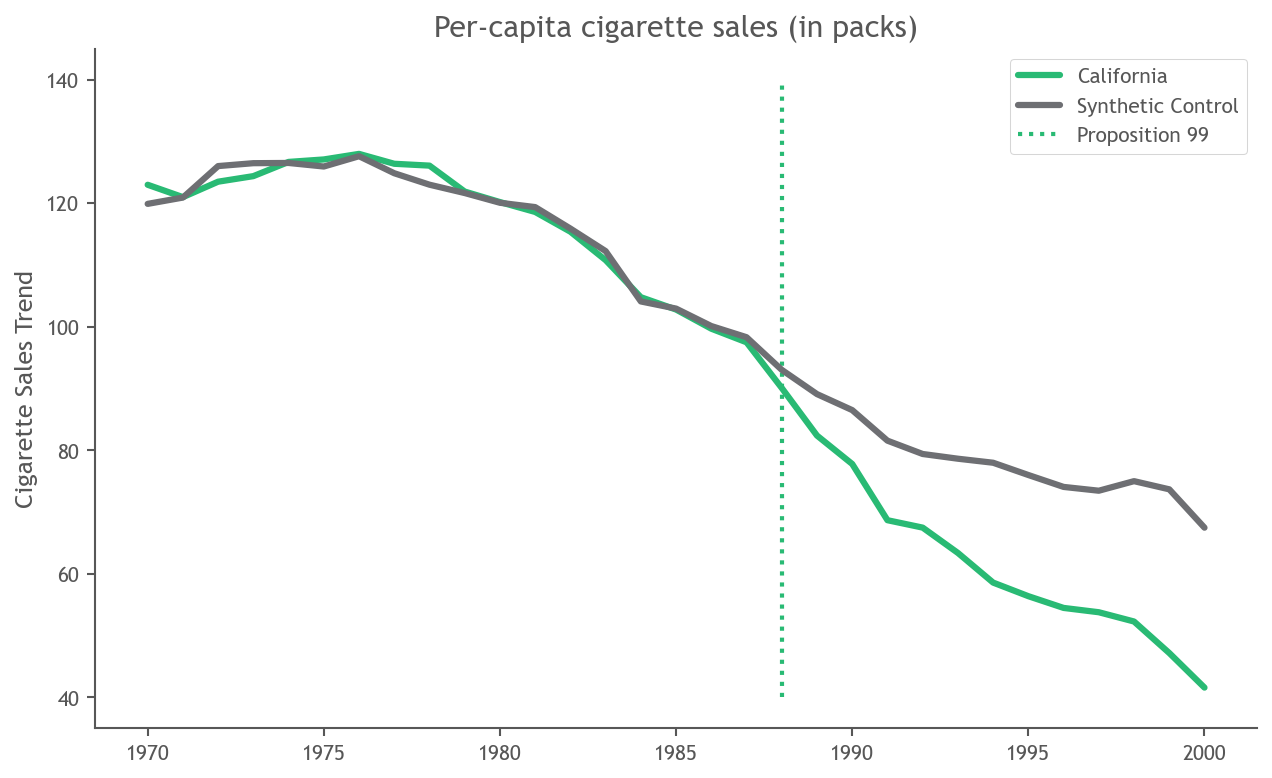

<IPython.core.display.Javascript object>

In [12]:
model_EN = ElasticNet(fit_intercept=False, positive=True)
cal, weights = create_synthetic_control(
    train_df, inverted, state_pools, model=model_EN, state="California"
)

print_actual_synth(cal, state="California")

## Outliers

Here we premute the treated and control exhaustively. Since we only have one treated unit, this means that for each unit, we pretend it is the treated while the others are the control. 

in the end, we will have one synthetic control and effect estimates for each state. What this does is it pretends that the treatment actually happened for another state, not California, and see what would have been the estimated .

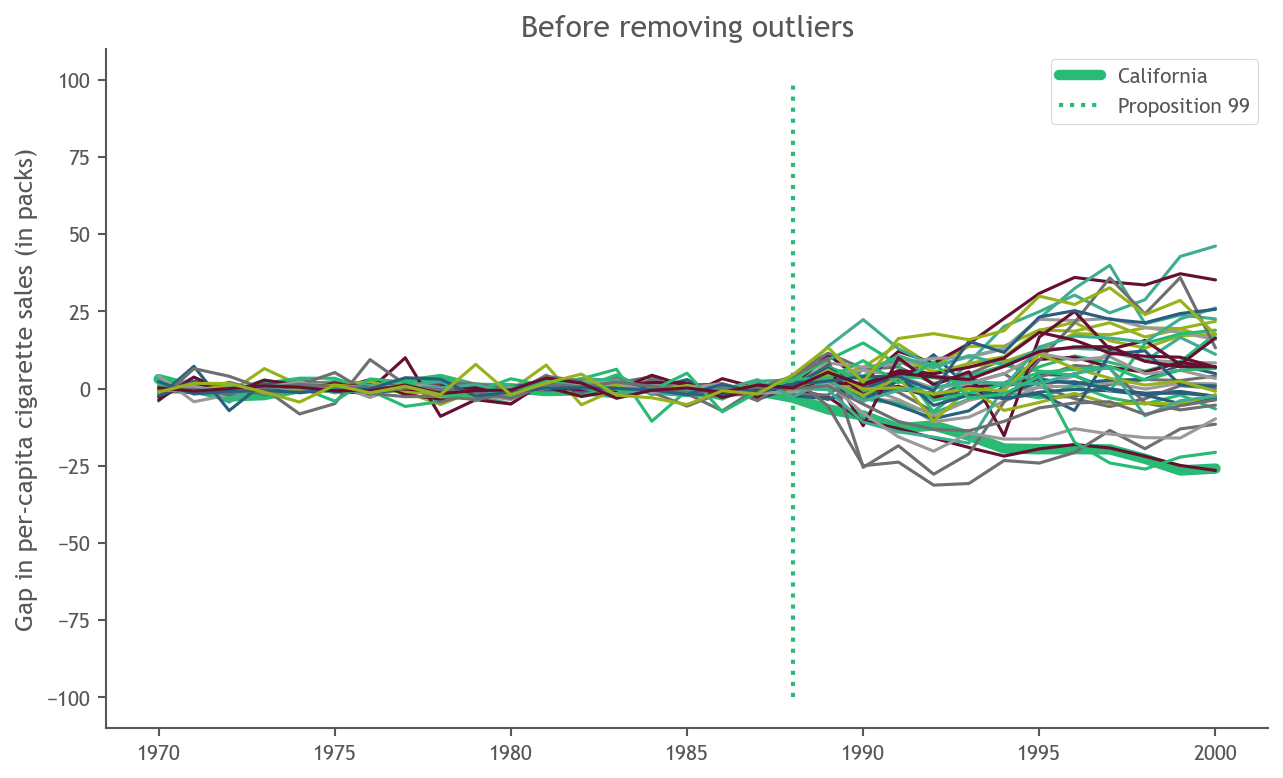

<IPython.core.display.Javascript object>

In [13]:
def synthetic_control(state, data):
    train_df = data.loc[:1988]
    use_cols = [x for x in data.columns if not x.endswith("_gap") and x != state]
    y = train_df[state].values  # treated state
    X = train_df[use_cols].values  # other states

    weights = Lasso(fit_intercept=False).fit(X, y).coef_

    synth = data[use_cols].dot(weights)

    data[state + "_gap"] = data[state] - synth
    return data


outlier_data = inverted.copy()
for state in outlier_data.columns:
    outlier_data = synthetic_control(state, outlier_data)

plt.figure(figsize=(10, 6))

plt.plot(
    cal.index,
    cal["gap"],
    label="California",
    lw=5,
)
for state in [x for x in outlier_data.columns if x.endswith("_gap")]:
    plt.plot(outlier_data.index, outlier_data[state])

plt.vlines(x=1988, ymin=-100, ymax=100, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Before removing outliers")
plt.legend()

Here, 2 things jumped out: 
1. the variance after the intervention is higher than the variance before intervention. This is expected since the synthetic control is designed to minimize the difference in the pre-intervention period.
2. There are some states we can't fit very well even in the pre-intervention period. This is also to be expected, since these might be outliers. 

Since the states are pooly fit, we would remove those outliers from our analysis. 

One way to do this is to make a cut with the mean squared error pre intervention. 

Upper percentile of mse is 5.369488375865694
removing outliers:
             State        mse
3      Connecticut   5.474684
9             Iowa  13.679449
10          Kansas   5.440212
14       Minnesota   5.992962
15     Mississippi   8.916232
20   New Hampshire  14.930626
21      New Mexico  19.287343
28  South Carolina   7.034796
34        Virginia   7.545174
38      California   9.950632


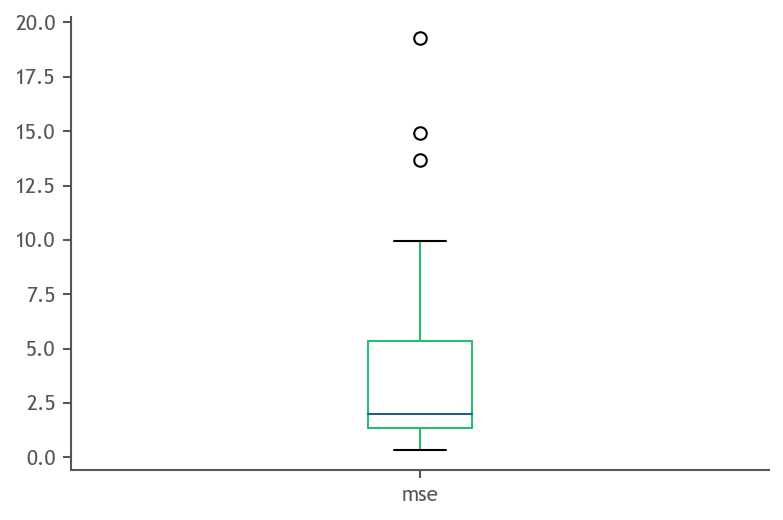

<IPython.core.display.Javascript object>

In [14]:
# Here we remove the outliers that are over a certain percentile


def identify_outliers(data, percentile):
    train_df = outlier_data.loc[:1988]
    gap_cols = [x for x in train_df.columns if x.endswith("_gap")]
    traim_mse = (train_df[gap_cols] ** 2).mean().reset_index()
    traim_mse.columns = ["State", "mse"]
    traim_mse["State"] = df["State"].str.replace(r"_gap", "")

    traim_mse.boxplot()

    upper_percentile = np.percentile(traim_mse.mse.values, q=percentile)
    print(f"Upper percentile of mse is {upper_percentile}")

    outliers = traim_mse[(traim_mse["mse"] > upper_percentile)]
    print("removing outliers:")
    print(outliers)
    return traim_mse[(traim_mse["mse"] <= upper_percentile)]["State"].to_list()


non_outlier_state = identify_outliers(outlier_data, percentile=75)

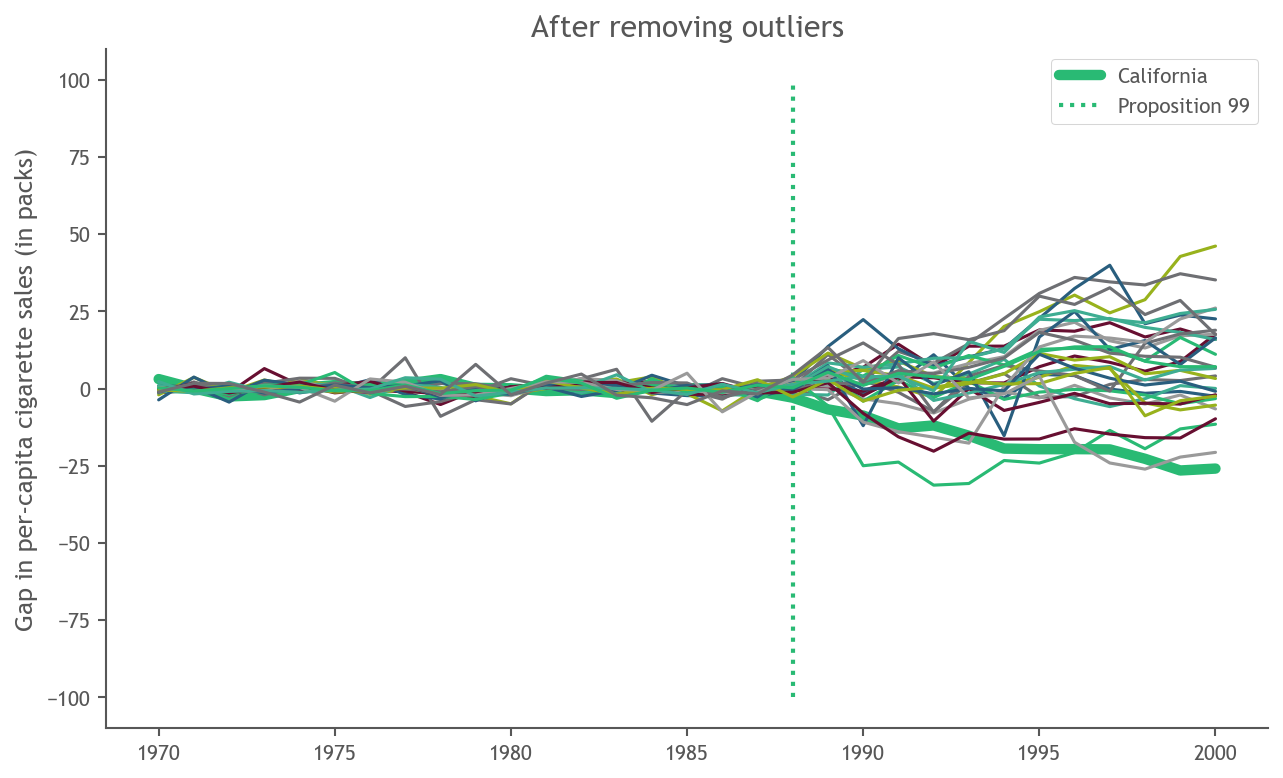

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(
    cal.index,
    cal["gap"],
    label="California",
    lw=5,
)
for state in non_outlier_state:
    plt.plot(outlier_data.index, outlier_data[state + "_gap"])

plt.vlines(x=1988, ymin=-100, ymax=100, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("After removing outliers")
plt.legend()

## Recalculate california synthetic control after removing noise

State weights : 
       State  weights
2   Colorado    0.320
14    Nevada    0.241
6   Illinois    0.130
3   Delaware    0.050
5      Idaho    0.043
12   Montana    0.036
28   Wyoming    0.004
13  Nebraska    0.002


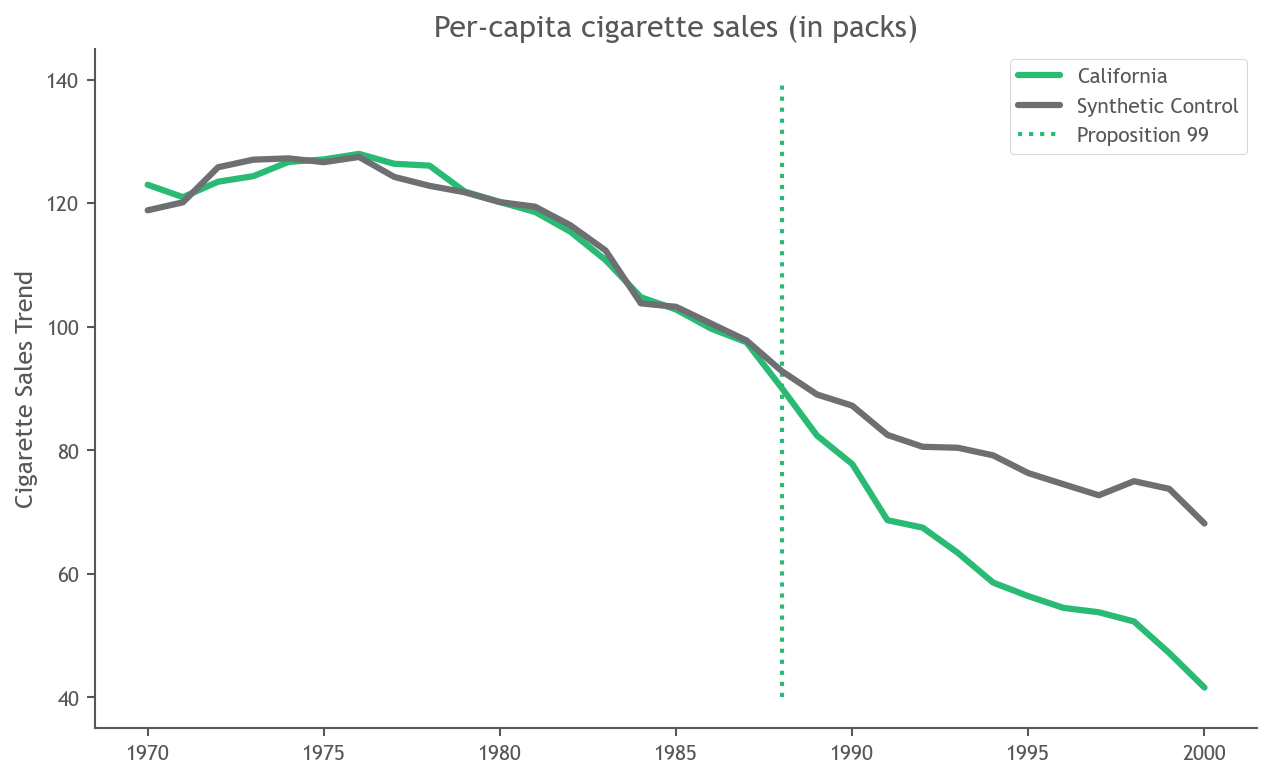

<IPython.core.display.Javascript object>

In [16]:
# Use the non outlier states as new pool
model_EN = ElasticNet(fit_intercept=False, positive=True)
cal_non_outlier, weights = create_synthetic_control(
    train_df, inverted, non_outlier_state, model=model_EN, state="California"
)

print_actual_synth(cal_non_outlier, state="California")

## Confidence Intervals

In [17]:
test_df = cal_non_outlier.loc[1990:]
test_df["lift"] = test_df["gap"] / test_df["synth"]
data = test_df["lift"]

<IPython.core.display.Javascript object>

In [18]:
# Sample mean
x_bar = data.mean()
x_bar

-0.2502199143349404

<IPython.core.display.Javascript object>

Confidence Intervals Using the t Distribution

If we’re working with a small sample (n <30), we can use the t.interval() function from the scipy.stats library to calculate a confidence interval for a population mean.

In [19]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)  # Mean and standard error
    # t distribution margin of error
    h = se * st.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h

<IPython.core.display.Javascript object>

In [20]:
mean_confidence_interval(data)

(-0.2502199143349404, -0.30690450934438884, -0.19353531932549192)

<IPython.core.display.Javascript object>

In [21]:
# Or simply use one line of code here
st.t.interval(alpha=0.95, df=len(data) - 1, loc=np.mean(data), scale=st.sem(data))

(-0.30690450934438884, -0.19353531932549192)

<IPython.core.display.Javascript object>

Confidence Intervals Using the Normal Distribution

If we’re working with larger samples (n≥30), we can assume that the sampling distribution of the sample mean is normally distributed (thanks to the Central Limit Theorem) and can instead use the norm.interval() function from the scipy.stats library.

In [22]:
# create 95% confidence interval for population mean weight
st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))

(-0.3000820513372111, -0.2003577773326697)

<IPython.core.display.Javascript object>

## Placebo state

SCM does not offer standard errors, which makes it harder to get the significance of performance outcome. One way to evaluate this is to perform a placebo test. 

Placebo tests are more commonly used in medical experiments. During a drug experiment, patients who are administrated drugs tend to show a positive recovery as they believe that the new drug will recover them. This psychological effect also impact the outcome of the experiment. To avoid this, placebos were introduced. Hence the actual impact of the drug will be measured as the difference between the treatment with and without placebo. 

This practice can be used measure the effectiveness of the SCM as well. The treatment state is replaced with one or many of the control state and synthetic control is generated for this control state. This will prove that there is no identifiable effect on the control from the treatment.  

In [23]:
# Find the state that has the highest corr with California pre 1989
train_df.corr()["California"].sort_values(ascending=False).head()

State
California       1.000000
New Hampshire    0.957438
Nevada           0.932807
Montana          0.930455
Colorado         0.926956
Name: California, dtype: float64

<IPython.core.display.Javascript object>

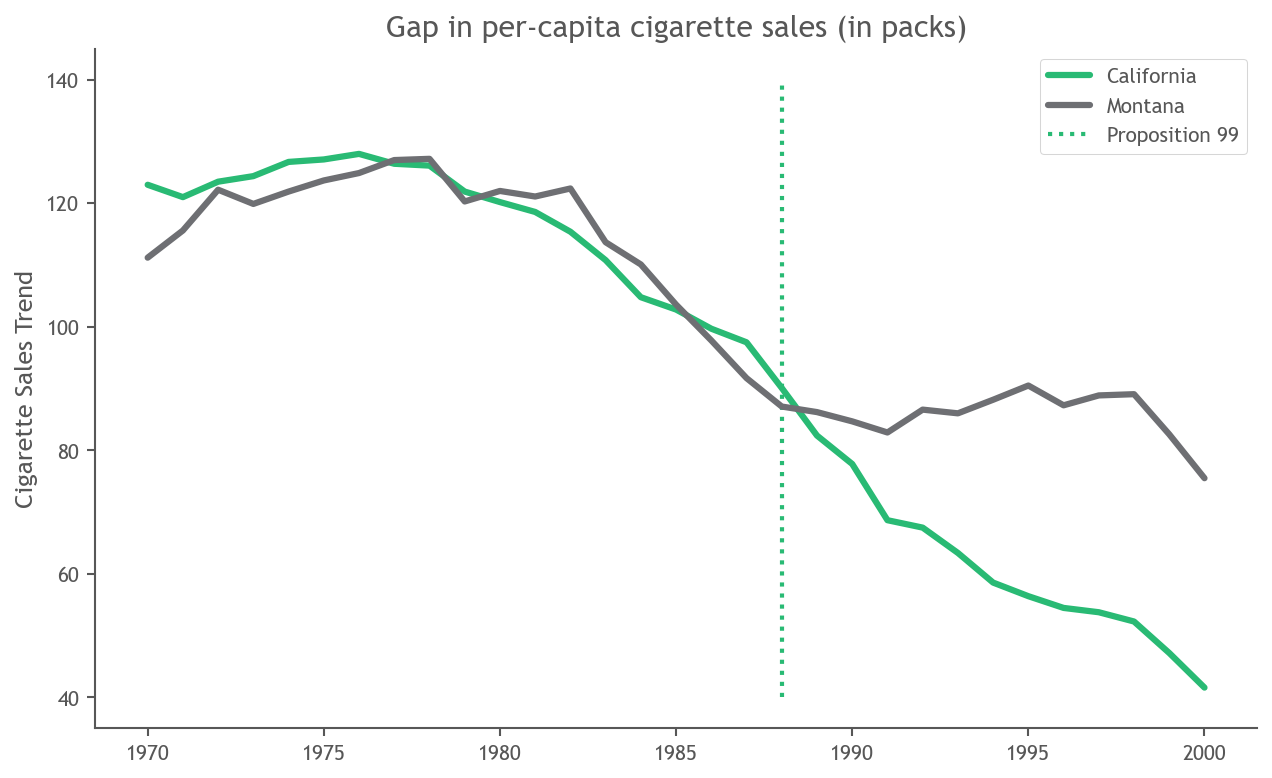

<IPython.core.display.Javascript object>

In [24]:
# Montana has similar scale of sales compare to California

plt.figure(figsize=(10, 6))

plt.plot(
    inverted.index,
    inverted["California"],
    label="California",
    lw=3,
)
plt.plot(
    inverted.index,
    inverted["Montana"],
    label="Montana",
    lw=3,
)

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()

State weights : 
             State  weights
2         Colorado    0.472
5            Idaho    0.160
15    North Dakota    0.128
27         Wyoming    0.084
25   West Virginia    0.024
13          Nevada    0.023
6         Illinois    0.016
14  North Carolina    0.016


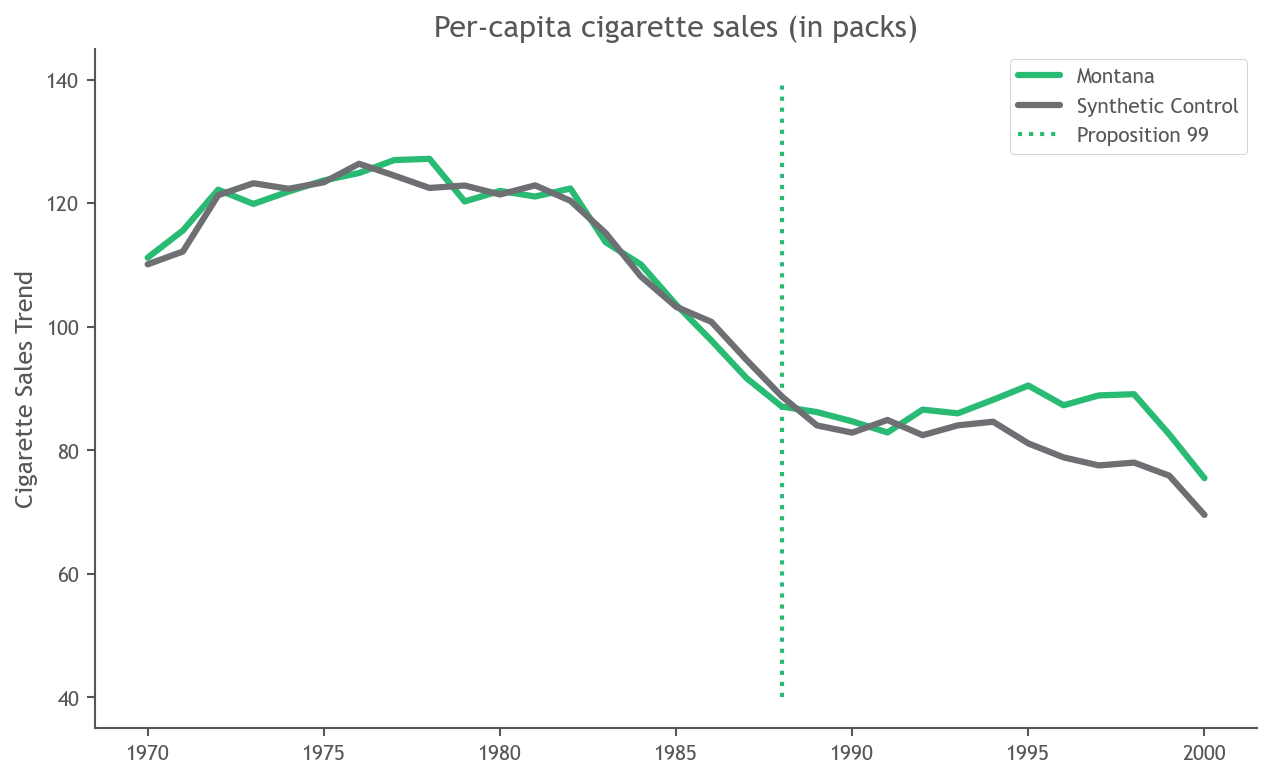

<IPython.core.display.Javascript object>

In [25]:
non_outlier_state_MO = [x for x in non_outlier_state if x != "Montana"]
model_EN = ElasticNet(fit_intercept=False, positive=True)
mon_non_outlier, mon_weights = create_synthetic_control(
    train_df, inverted, non_outlier_state_MO, model=model_EN, state="Montana"
)

print_actual_synth(mon_non_outlier, state="Montana")

In [26]:
test_df = mon_non_outlier.loc[1990:]
test_df["lift"] = test_df["gap"] / test_df["synth"]
data = test_df["lift"]
mean_confidence_interval(data)

(0.07250751767040962, 0.036094979268137824, 0.10892005607268143)

<IPython.core.display.Javascript object>

Treated California sales go down by 25.0% (mean lift) with CI [-30.7%,-19.4%]. In comparison, Montana untreated, placebo sales go up around 7.3%, with CI [3.6%, 10.9%]. Therefore, SCM measure signifies that the treatment was meaningful.